In [2]:
import pandas as pd
import numpy as np
# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Modelling
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
# import to create polynomial features
from sklearn.preprocessing import PolynomialFeatures

# import graphviz
# Scaling with Minmax-scaler
from sklearn.preprocessing import MinMaxScaler

# from ydata_profiling import ProfileReport

# import custom functions
from custom_functions import our_metrics
from custom_functions import comb_metrics

# import custom scorers
from custom_functions import get_kappa

# pd.set_option('display.max_rows', None)

from scipy.stats import loguniform

RSEED = 42

## Importing the Data

In [3]:
# reading in the data sets (for distance based models with dropped first column during dummy creation in order to avoid collinearity)
X_test = pd.read_csv('../data/petfinder-adoption-prediction/train/X_test_minmax_scaled_dropped_first.csv', delimiter=',')
X_train = pd.read_csv('../data/petfinder-adoption-prediction/train/X_train_minmax_scaled_dropped_first.csv', delimiter=',')
y_test = pd.read_csv('../data/petfinder-adoption-prediction/train/y_test.csv', delimiter=',')
y_train = pd.read_csv('../data/petfinder-adoption-prediction/train/y_train.csv', delimiter=',')

In [6]:
# change format of y from dataframe to array
y_test = np.ravel(y_test)
y_train = np.ravel(y_train)
y_train_cats = np.ravel(y_train_cats)
y_train_dogs = np.ravel(y_train_dogs)
y_test_cats = np.ravel(y_test_cats)
y_test_dogs = np.ravel(y_test_dogs)

In [7]:
# import the vectorized description column
X_train_vectorized = pd.read_pickle('../data/X_train_vectorized.pkl') 
X_test_vectorized = pd.read_pickle('../data/X_test_vectorized.pkl') 

In [8]:
X_test_vectorized.shape

(2892, 15958)

In [11]:
X_train_nlp = pd.concat([X_train, X_train_vectorized], axis=1)
X_test_nlp = pd.concat([X_test, X_test_vectorized], axis=1)

In [13]:
# convert all column headers to string

X_train_nlp.columns = X_train_nlp.columns.astype(str)
X_test_nlp.columns = X_test_nlp.columns.astype(str)

## Predictive Modelling with a Logistic Regression

### Baseline

we assume the default logistic regression without vectorized description text to be the baseline:
Accuracy Train: 0.39, Kappa Train: 0.29
Accuracy Test: 0.39, Kappa Test: 0.30 

### Default Logistic Regression with vectorized description text

In [15]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_nlp, y_train)

y_pred_train_nlp = log_reg.predict(X_train_nlp)
y_pred_test_nlp = log_reg.predict(X_test_nlp)

/Users/annastein/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/annastein/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/annastein/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.8517
_____________________
Weighted Quadratic Kappa: 0.8149


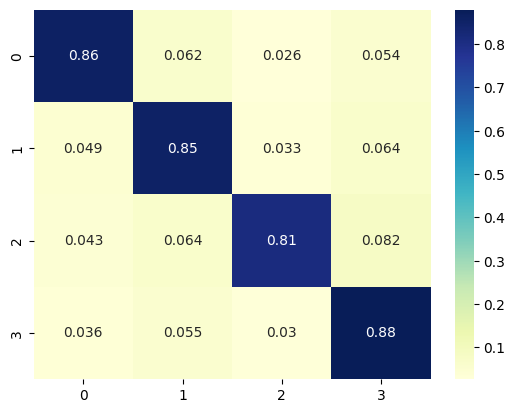

In [16]:
our_metrics(y_train, y_pred_train_nlp, normalize=True)

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.3046
_____________________
Weighted Quadratic Kappa: 0.1289


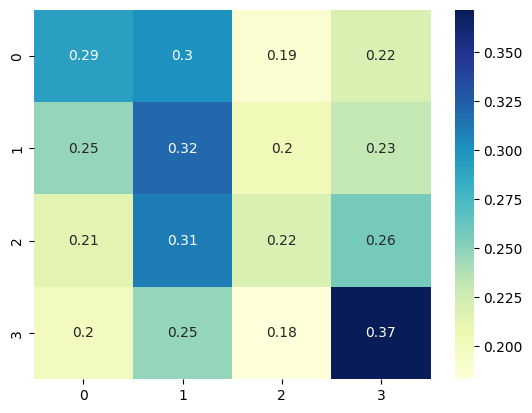

In [17]:
our_metrics(y_test, y_pred_test_nlp, normalize=True)

## Hyperparameter Tuning with Random Search 

In [14]:
#what parameters does LogisticRegression have?
log_reg.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

### Hyperparameters of the LogisticRegression

- 'C' : float, default=1.0
Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
- 'class_weight' : dict or ‘balanced’, default=None
Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one.
- 'dual' : bool, default=False
Dual or primal formulation. Dual formulation is only implemented for l2 penalty with liblinear solver. Prefer dual=False when n_samples > n_features.
- 'fit_intercept' : bool, default=True
Specifies if a constant (a.k.a. bias or intercept) should be added to the decision function.
- 'intercept_scaling' : float, default=1
Useful only when the solver ‘liblinear’ is used and ...
- 'l1_ratio': float, default=None
The Elastic-Net mixing parameter, with 0 <= l1_ratio <= 1. Only used if penalty='elasticnet'. Setting l1_ratio=0 is equivalent to using penalty='l2', while setting l1_ratio=1 is equivalent to using penalty='l1'. For 0 < l1_ratio <1, the penalty is a combination of L1 and L2.
- 'max_iter' : int, default=100
Maximum number of iterations taken for the solvers to converge
- 'multi_class': {‘auto’, ‘ovr’, ‘multinomial’}, default=’auto’
If the option chosen is ‘ovr’, then a binary problem is fit for each label. For ‘multinomial’ the loss minimised is the multinomial loss fit across the entire probability distribution, even when the data is binary. ‘multinomial’ is unavailable when solver=’liblinear’. ‘auto’ selects ‘ovr’ if the data is binary, or if solver=’liblinear’, and otherwise selects ‘multinomial’.
- n_jobs': int, default=None
- 'penalty' : {‘l1’, ‘l2’, ‘elasticnet’, None}, default=’l2’
- 'random_state' : int, RandomState instance, default=None
Used when solver == ‘sag’, ‘saga’ or ‘liblinear’ to shuffle the data.
- 'solver' : {‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’}, default=’lbfgs’
Algorithm to use in the optimization problem. Default is ‘lbfgs’. To choose a solver, you might want to consider the following aspects:
For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones;
For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss;
‘liblinear’ is limited to one-versus-rest schemes.
‘newton-cholesky’ is a good choice for n_samples >> n_features, especially with one-hot encoded categorical features with rare categories. Note that it is limited to binary classification and the one-versus-rest reduction for multiclass classification. Be aware that the memory usage of this solver has a quadratic dependency on n_features because it explicitly computes the Hessian matrix.
Warning: The choice of the algorithm depends on the penalty chosen. Supported penalties by solver:
‘lbfgs’ - [‘l2’, None]
‘liblinear’ - [‘l1’, ‘l2’]
‘newton-cg’ - [‘l2’, None]
‘newton-cholesky’ - [‘l2’, None]
‘sag’ - [‘l2’, None]
‘saga’ - [‘elasticnet’, ‘l1’, ‘l2’, None]
- 'tol' : float, default=1e-4
Tolerance for stopping criteria.
- 'verbose' : int, default=0
For the liblinear and lbfgs solvers set verbose to any positive number for verbosity.
- 'warm_start' : bool, default=False
When set to True, reuse the solution of the previous call to fit as initialization, otherwise, just erase the previous solution. Useless for liblinear solver.

## RandomSearch with Quadratic Weighted Kappa Scorer

In [29]:
 # Define parameter grid for randomized search
param_grid_kappa = {#'C' : loguniform(1e-5, 200),
              'C' : np.linspace(0.1, 10, 50),
#              'l1_ratio' : np.linspace(0, 1, 20), 
              'penalty' : ['l1', 'l2', None],#, 'elasticnet'],
              'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
#              'class_weight' : ['balanced', None]
             }

In [30]:
# make the kappa scorers needed for the grid search
kappa_scorer = get_kappa()

In [31]:
# Instantiate random search and define the metric to optimize 
rs_kappa = RandomizedSearchCV(LogisticRegression(random_state=RSEED,max_iter=1000), param_grid_kappa, scoring=kappa_scorer,
                  cv=5, verbose=0, n_jobs=-1, n_iter=50, random_state=RSEED)

In [32]:
# Fit randomized search object to data
rs_kappa.fit(X_train, y_train)

/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.

/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/pyth

RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=1000, random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'C': array([ 0.1       ,  0.30204082,  0.50408163,  0.70612245,  0.90816327,
        1.11020408,  1.3122449 ,  1.51428571,  1.71632653,  1.91836735,
        2.12040816,  2.32244898,  2.5244898 ,  2.72653061,  2.92857143,
        3.13061224,  3.33265306,  3.53469388,  3.73673469,  3.93877551,
        4.1...
        6.16122449,  6.36326531,  6.56530612,  6.76734694,  6.96938776,
        7.17142857,  7.37346939,  7.5755102 ,  7.77755102,  7.97959184,
        8.18163265,  8.38367347,  8.58571429,  8.7877551 ,  8.98979592,
        9.19183673,  9.39387755,  9.59591837,  9.79795918, 10.        ]),
                                        'penalty': ['l1', 'l2', None],
                                        'solver': ['lbfgs', 'liblinear',
                                                   'newton-cg',
                                                   'newton-cholesky', 'sag',
                                                   'saga']},
                   random_state=42,
                   scoring=make_scorer(cohen_kappa_score, weights=quadratic))

In [33]:
# Best score
print('Best score:', round(rs_kappa.best_score_, 3))

# Best parameters
print('Best parameters:', rs_kappa.best_params_)

Best score: 0.287
Best parameters: {'solver': 'saga', 'penalty': 'l1', 'C': 0.3020408163265306}


Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.389
_____________________
Weighted Quadratic Kappa: 0.2903


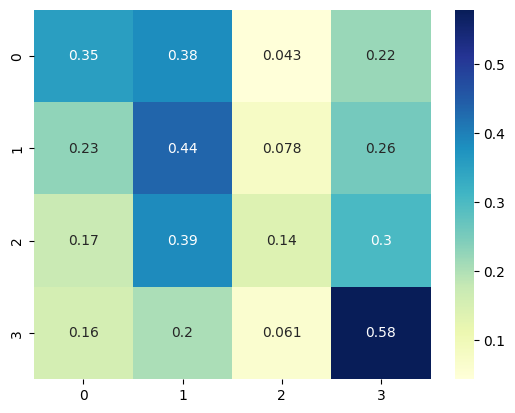

In [34]:
# Assigning the fitted LogisticRegression model with best parameter combination to a new variable log_reg_best_rs_kappa
log_reg_best_rs_kappa = rs_kappa.best_estimator_

# Making predictions on the test set
y_pred_test_rs_kappa = log_reg_best_rs_kappa.predict(X_test)

# Let us print out the performance of our model on the test set.
our_metrics(y_test, y_pred_test_rs_kappa, normalize=True)

In [35]:
# y_pred_train_rs_kappa = log_reg_best_rs_kappa.predict(X_train)
# our_metrics(y_train, y_pred_train_rs_kappa, normalize=True)

## GridSearch

In [46]:
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [47]:
# Defining parameter grid (as dictionary)
# default logistic regression: : C=1 , penalty l2, solver='lbfgs'
param_grid_gs = {"C" : [0.2, 0.5, 1, 2, 5, 10, 15, 20],
              "penalty" : ["l2", "l1", None],
              'solver' : ['lbfgs', 'saga', 'liblinear', 'newton-cholesky'],
#              'class_weight' : ['balanced', None]
             }

### GridSearch with Kappa-Scorer

In [53]:
# Instantiate gridsearch and define the metric to optimize 
gs_cats_kappa = GridSearchCV(LogisticRegression(random_state=RSEED), param_grid_gs, scoring=kappa_scorer,
                  cv=5, verbose=0, n_jobs=-1)

# Fit gridsearch object to data.. also lets see how long it takes
gs_cats_kappa.fit(X_train_cats, y_train_cats)

/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.

/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_rati

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.2, 0.5, 1, 2, 5, 10, 15, 20],
                         'penalty': ['l2', 'l1', None],
                         'solver': ['lbfgs', 'saga', 'liblinear',
                                    'newton-cholesky']},
             scoring=make_scorer(cohen_kappa_score, weights=quadratic))

In [54]:
# Best score
print('Best score:', round(gs_cats_kappa.best_score_, 3))

# Best parameters
print('Best parameters:', gs_cats_kappa.best_params_)
# Assigning the fitted LogisticRegression model with best parameter combination to a new variable log_reg_best_rs_kappa
log_reg_best_gs_cats_kappa = gs_cats_kappa.best_estimator_

Best score: 0.261
Best parameters: {'C': 0.2, 'penalty': None, 'solver': 'newton-cholesky'}


In [55]:
# Making predictions on the test set
y_pred_test_gs_cats_kappa = log_reg_best_gs_cats_kappa.predict(X_test_cats)

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.407
_____________________
Weighted Quadratic Kappa: 0.2933


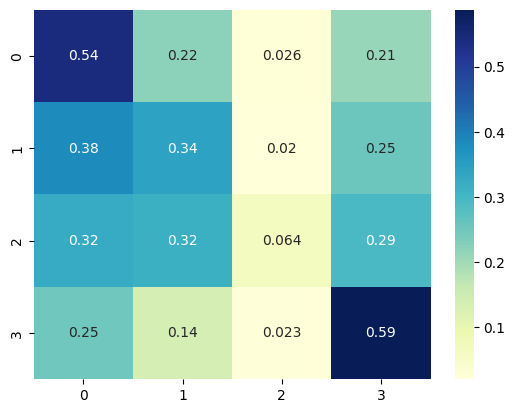

In [56]:
our_metrics(y_test_cats, y_pred_test_gs_cats_kappa, normalize=True)

In [57]:
# Instantiate gridsearch and define the metric to optimize 
gs_dogs_kappa = GridSearchCV(LogisticRegression(random_state=RSEED), param_grid_gs, scoring=kappa_scorer,
                  cv=5, verbose=0, n_jobs=-1)

# Fit gridsearch object to data.. also lets see how long it takes
gs_dogs_kappa.fit(X_train_dogs, y_train_dogs)

/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.2, 0.5, 1, 2, 5, 10, 15, 20],
                         'penalty': ['l2', 'l1', None],
                         'solver': ['lbfgs', 'saga', 'liblinear',
                                    'newton-cholesky']},
             scoring=make_scorer(cohen_kappa_score, weights=quadratic))

In [58]:
# Best score
print('Best score:', round(gs_dogs_kappa.best_score_, 3))

# Best parameters
print('Best parameters:', gs_dogs_kappa.best_params_)

Best score: 0.365
Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}


In [59]:
# Assigning the fitted LogisticRegression model with best parameter combination to a new variable log_reg_best_rs_kappa
log_reg_best_gs_dogs_kappa = gs_dogs_kappa.best_estimator_

In [60]:
# Making predictions on the test set
y_pred_test_gs_dogs_kappa = log_reg_best_gs_dogs_kappa.predict(X_test_dogs)

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.3998
_____________________
Weighted Quadratic Kappa: 0.3244


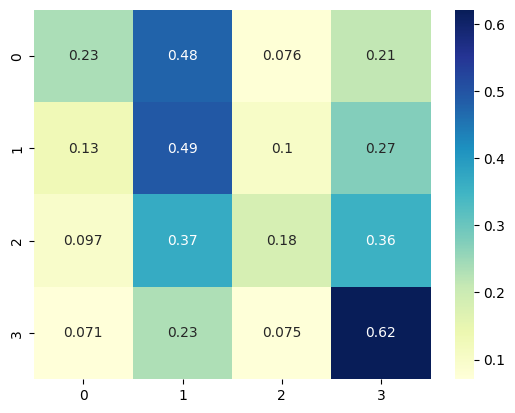

In [61]:
our_metrics(y_test_dogs, y_pred_test_gs_dogs_kappa, normalize=True)

## Best Models

Comparing the different models, we see that with regard to the kappa score, the following models perform best with the given scores on the test data set:

* Cats data : Default LogisticRegression;  Accuracy = 40.29 % and kappa = 0.2964
* Dogs data : LogisticRegression with PolynomialFeatures; Accuracy 39.55 % and kappa = 0.3413
* Combined Data : LogisticRegression with PolynomialFeatures; Accuracy 40.42 % and kappa = 0.341